In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import train_test_split


In [8]:
# Read sample metadata from the Schubert study
abx_cdiff_metadata = pd.read_csv(\
        '../data/Schubert_AbxD01_mBio_2015/data/process/abxD1.counts',\
        sep='\t')
# Read the operational taxonomic unit (OTU) abundance file
otu_data = pd.read_csv(\
        '../data/Schubert_AbxD01_mBio_2015/data/process/' +\
        'abxD0.trim.contigs.good.unique.good.filter.unique.' +\
        'precluster.pick.pick.pick.an.unique_list.0.03.subsample.shared',\
        sep='\t')

# Drop extra columns from the DataFrame (in this case, "label" corresponds to a cutoff used in the preprocessing
# steps, and "Unnamed:820" is an extra column generated during the input/output process, filled with NAs)
otu_data = otu_data.drop('Unnamed: 820',1)
otu_data = otu_data.drop('label',1)

# change row names to "group" column
otu_data = otu_data.set_index('Group')
# remove OTUs not present in more than one sample.
# This is a common filtering procedure, and people often vary the stringency in papers (e.g. more than 10 samples)
for column in otu_data.columns:
    if sum(otu_data[column]) < 1:
        otu_data = otu_data.drop(column,1)

# reformat input data as numpy matrix with accompanying labels for each row
# Labels will be cdiff CFU count
abx_cdiff_metadata = abx_cdiff_metadata.set_index('Group')
abx_cdiff_metadata.fillna(value=0,inplace=True)
# merge the OTU abundance dataframe with the metadata dataframe
otus_w_metadata = otu_data.merge(abx_cdiff_metadata,left_index=True,right_index=True)
# Drop some of the metadata that we won't be using (for now)
df_for_formatting = otus_w_metadata.drop(['abx','dose','experiment','numOtus'],1)

#Now this is what our dataframe looks like:
df_for_formatting

,Otu00001,Otu00002,Otu00003,Otu00004,Otu00005,Otu00006,Otu00007,Otu00008,Otu00009,Otu00010,...,Otu01682,Otu01694,Otu01711,Otu01714,Otu01715,Otu01719,Otu01729,Otu01738,Otu01760,CFU
Group,,,,,,,,,,,,,,,,,,,,,
004-1D0,3,0,1145,1,0,1,425,3,0,0,...,0,0,0,0,0,0,0,0,0,60000000
004-2D0,17,7,1371,3,2,0,210,3,1,0,...,0,0,0,0,0,0,0,0,0,7300000
004-359D0,9,2,1288,2,2,0,271,2,1,0,...,0,0,0,0,0,0,0,0,0,23300000
004-4D0,9,0,1410,3,1,0,194,0,1,0,...,0,0,0,0,0,0,0,0,0,110000
007-1D0,0,0,255,889,0,0,352,0,1,0,...,0,0,0,0,0,0,0,0,0,0
007-2D0,2,0,205,1077,0,0,290,0,0,0,...,1,0,0,0,0,0,0,0,0,0
007-357D0,1,0,255,964,0,0,298,0,0,0,...,0,0,0,0,0,0,0,0,0,0
007-358D0,1,0,267,954,2,0,253,0,1,0,...,0,0,0,0,0,0,0,0,0,0
015-1D0,19,69,1,20,450,147,28,111,0,86,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#convert to label and value arrays for sklearn input
labels = np.log(df_for_formatting.as_matrix(columns=['CFU'])) # Amount of C. difficile in feces is our outcome
# variable or dependent variable that we'd like to predict.

labels[np.isneginf(labels)] = 0 # taking the log of 0 often results in negative infinity, so we'll correct as 0
values = df_for_formatting.drop('CFU',1).as_matrix() # Prep our OTU data for training by removing the outcome
                                                     # variable, CFU of C. difficile, form the dataframe

In [12]:
# Create a test and train split with the sklearn function we imported.
# Although ensemble-based learners don't really need a test/train split because each individual learner
# is trained on a subset of the data, we'll do so for now just in case we'd like to try other 
# algorithms (e.g. SVM or neural network) and need a way to compare performance.
X_train, X_test, y_train, y_test = train_test_split(values, labels, test_size = 0.33, random_state=42)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


11.9593765883


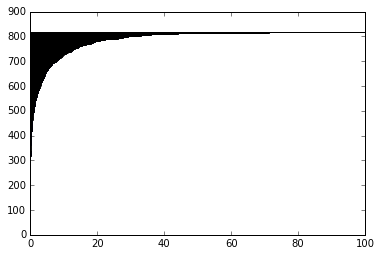

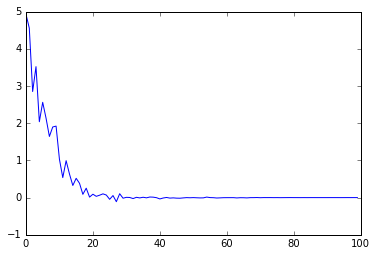

In [13]:
# Create a gradient boosting regressor. This model is constructed from 100 decision tree regressors, and trained in
# a "boosting" fashion. The sklearn site has a bit of documentation on boosting, but it's probably best to consult
# the original papers by Friedman if you'd like actual details for functionality.
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,\
                               max_depth=20, subsample=0.5, max_features=20,\
                               random_state=0, loss='ls').fit(X_train,y_train)


print mean_squared_error(y_test,est.predict(X_test)) # This is one potential performance metric

# We can extract feature importance from a trained model, which is a measure of how much each covariate
# (each OTU) in this case, affects regression when removed.
feature_importance = est.feature_importances_
feature_importance = 100.0* (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance) # Get the sorted indices of OTUs, from highest importance to lowest
pos = np.arange(sorted_idx.shape[0]) + 0.5 # This is just the position vector for the bar chart
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.show()
plt.plot(est.oob_improvement_) # This plots the improvement in the regression loss function during training. We 
                               # can see fairly quick convergence.
plt.show()

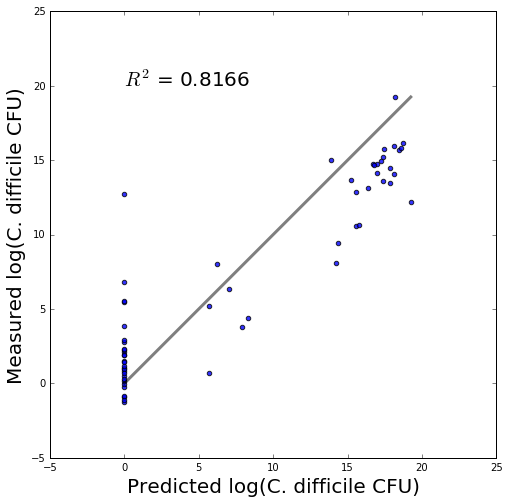

In [26]:

est_predict = est.predict(X_test) # Use the trained model to predict C diff burden on test data
est_R2 = est.score(X_test,y_test) # Calculate R^2 value for the test set predictions

fig, ax = plt.subplots(1,1) # Initialize figure and axes objects for plotting. We don't use the fig object here,
                            # but it's useful for adjusting the canvas size and other attributes.
ax.scatter(y_test, est_predict, alpha = 0.8, c='Blue') # Plot the prediction vs. measured value for test set

# show the "perfect prediction" line
ax.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'k-', lw=3, alpha=0.5) 
ax.annotate('$R^2$ = ' + str(round(est_R2,4)),xy=(0,20),fontsize=20) # add R^2 value to plot
ax.set_xlabel('Predicted log(C. difficile CFU)',fontsize=20)
ax.set_ylabel('Measured log(C. difficile CFU)',fontsize=20)
fig.set_size_inches(8,8)
plt.show()